# PSD

author: steeve.laquitaine@epfl.ch

last modified: 24.10.2024

## Setup

1. Setup `spikeinterf..` virtual environment

2. Compute the power spectral densities of the entire recordings (multi-nodes multi-core, 10m): 

    sbatch cluster/validation/psd/mpi_npx_full.sh  
    sbatch cluster/validation/psd/mpi_dense_full.sh

In [13]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)


from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000          # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000          # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# SETUP DATASETS

# neuropixels *********************

# neuropixels (Marques-Smith)
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["probe_wiring"]["full"]["output"]
PREP_PATH_nv = cfg_nv["preprocessing"]["full"]["output"]["trace_file_path"]
PRE_PSD_PATH_NV = cfg_nv["validation"]["psd"]["preprocessed"]

# neuropixels (biophy. spont.)
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH_ns = cfg_ns["probe_wiring"]["full"]["output"]
PREP_PATH_ns = cfg_ns["preprocessing"]["full"]["output"]["trace_file_path"]
PRE_PSD_PATH_NS = cfg_ns["validation"]["psd"]["preprocessed"]

# neuropixels (evoked biophy.)
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["full"]["output"]
PRE_PATH_NE = cfg_ne["preprocessing"]["full"]["output"]["trace_file_path"]
PRE_PSD_PATH_NE = cfg_ne["validation"]["psd"]["preprocessed"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
PRE_PSD_PATH_NB = cfg_nb["validation"]["psd"]["preprocessed"]

# custom *******************
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
RAW_PATH_hv1 =  cfg_hv1["probe_wiring"]["full"]["output"]
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv2 =  cfg_hv2["probe_wiring"]["full"]["output"]
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
RAW_PATH_hv3 =  cfg_hv3["probe_wiring"]["full"]["output"]
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["preprocessed"]
# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
RAW_PATH_hs1 = cfg_hs1["probe_wiring"]["full"]["output"]
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
RAW_PATH_hs2 = cfg_hs2["probe_wiring"]["full"]["output"]
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_hs3 = cfg_hs3["probe_wiring"]["full"]["output"]
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["preprocessed"]


# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-10-24 12:40:29,772 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 12:40:29,904 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 12:40:29,908 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 12:40:30,040 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 12:40:30,043 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 12:40:30,373 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 12:40:30,390 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 12:40:30,578 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 12:40:30,591 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 12:40:30,710 - root - utils.py - get_config - INFO - R

## Specs

## (1s)Load datasets

* select first 10 min for speed

In [9]:
# Load traces
# neuropixels
# raw
RawNV = si.load_extractor(RAW_PATH_nv)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
# preprocessed
PrepNV = si.load_extractor(PREP_PATH_nv)

# Dense probe
# raw (probe 1, 2, 3)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)
# preprocessed (probe 1, 2, 3)
PrepHV1 = si.load_extractor(PREP_PATH_hv1)
PrepHS1 = si.load_extractor(PREP_PATH_hs1)
PrepHV2 = si.load_extractor(PREP_PATH_hv2)
PrepHS2 = si.load_extractor(PREP_PATH_hs2)
PrepHV3 = si.load_extractor(PREP_PATH_hv3)
PrepHS3 = si.load_extractor(PREP_PATH_hs3)


# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# silico
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RawNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs (in cortex)
# neuropixels
# preprocessed
psd_pre_nv = np.load(PRE_PSD_PATH_NV, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()
# preprocessed
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test
assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

## (2s)AP power (NPX)

* power in the frequency band of the action potential (300 - 1000 Hz (a period of 1ms to 3 ms)

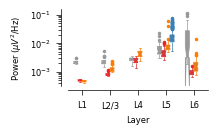

In [18]:
FIG_SIZE = (1.8, 1)

NORM = False

# calculate stats and plot data
d1 = power.get_psd_data_prepro(
    "L1",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d23 = power.get_psd_data_prepro(
    "L2_3",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d4 = power.get_psd_data_prepro(
    "L4",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d5 = power.get_psd_data_prepro_layer_5(
    "L5",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    psd_pre_nb,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)
d6 = power.get_psd_data_prepro(
    "L6",
    psd_pre_hv3,  # probe 3
    psd_pre_hs3,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv3[sites_hv3],  # probe 3
    site_ly_hs3[sites_hs3],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
    norm=NORM,
)

c_bot = 300  # spike with a period of 3 ms
c_up = 1000  # spike with a period of 0.5 ms

# Marques-Smith
df_nv1 = power.get_spiking_power(d1["psd_pre_nv_"], c_bot, c_up, "M", "L1")
df_nv23 = power.get_spiking_power(d23["psd_pre_nv_"], c_bot, c_up, "M", "L2_3")
df_nv4 = power.get_spiking_power(d4["psd_pre_nv_"], c_bot, c_up, "M", "L4")
df_nv5 = power.get_spiking_power(d5["psd_pre_nv_"], c_bot, c_up, "M", "L5")
df_nv6 = power.get_spiking_power(d6["psd_pre_nv_"], c_bot, c_up, "M", "L6")

# npx spontaneous
df_ns1 = power.get_spiking_power(d1["psd_pre_ns_"], c_bot, c_up, "NS", "L1")
df_ns23 = power.get_spiking_power(d23["psd_pre_ns_"], c_bot, c_up, "NS", "L2_3")
df_ns4 = power.get_spiking_power(d4["psd_pre_ns_"], c_bot, c_up, "NS", "L4")
df_ns5 = power.get_spiking_power(d5["psd_pre_ns_"], c_bot, c_up, "NS", "L5")
df_ns6 = power.get_spiking_power(d6["psd_pre_ns_"], c_bot, c_up, "NS", "L6")

# evoked
df_ne1 = power.get_spiking_power(d1["psd_pre_ne_"], c_bot, c_up, "E", "L1")
df_ne23 = power.get_spiking_power(d23["psd_pre_ne_"], c_bot, c_up, "E", "L2_3")
df_ne4 = power.get_spiking_power(d4["psd_pre_ne_"], c_bot, c_up, "E", "L4")
df_ne5 = power.get_spiking_power(d5["psd_pre_ne_"], c_bot, c_up, "E", "L5")
df_ne6 = power.get_spiking_power(d6["psd_pre_ne_"], c_bot, c_up, "E", "L6")

# synthetic
df_s5 = power.get_spiking_power(d5["psd_pre_nb_"], c_bot, c_up, "S", "L5")

# stack
plot_df_npx = pd.concat(
    [
        df_nv1,
        df_nv23,
        df_nv4,
        df_nv5,
        df_nv6,
        df_ns1,
        df_ns23,
        df_ns4,
        df_ns5,
        df_ns6,
        df_ne1,
        df_ne23,
        df_ne4,
        df_ne5,
        df_ne6,
        df_s5,
    ]
)

# standardize
plot_df_npx["Layer"][plot_df_npx["Layer"] == "L2_3"] = "L2/3"

# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_df_npx,
    x="Layer",
    y="power",
    hue="Experiment",
    notch=True,
    hue_order=["M", "NS", "E", "S"],
    palette=[cl["COLOR_NV"], cl["COLOR_NS"], cl["COLOR_NE"], cl["COLOR_NB"]],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
ax.set_yscale("log")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=5,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])
                ax.lines[k].set_mfc(cl["COLOR_NS"])
                ax.lines[k].set_mec(cl["COLOR_NS"])
            p += 1
        elif p in [10, 11, 12, 13, 14]:
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1
        elif p in [15]:
            box.set_edgecolor(cl["COLOR_NB"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NB"])
                ax.lines[k].set_mfc(cl["COLOR_NB"])
                ax.lines[k].set_mec(cl["COLOR_NB"])
            p += 1

# legend
ax.set_ylabel("Power ($\u03bcV^2$/Hz)")
ax.set_xlabel("Layer")

# save
plt.savefig("figures/0_validation/4_power/fig2S/AP_power_npx.svg", **savefig_cfg)

## (1s)AP power (dense probe)

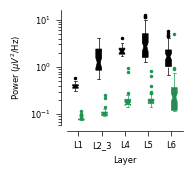

In [16]:
# Marques-Smith
df_hv1 = power.get_spiking_power(d1["psd_pre_hv_"], c_bot, c_up, "H", "L1")
df_hv23 = power.get_spiking_power(d23["psd_pre_hv_"], c_bot, c_up, "H", "L2_3")
df_hv4 = power.get_spiking_power(d4["psd_pre_hv_"], c_bot, c_up, "H", "L4")
df_hv5 = power.get_spiking_power(d5["psd_pre_hv_"], c_bot, c_up, "H", "L5")
df_hv6 = power.get_spiking_power(d6["psd_pre_hv_"], c_bot, c_up, "H", "L6")

# npx spontaneous
df_hs1 = power.get_spiking_power(d1["psd_pre_hs_"], c_bot, c_up, "DS", "L1")
df_hs23 = power.get_spiking_power(d23["psd_pre_hs_"], c_bot, c_up, "DS", "L2_3")
df_hs4 = power.get_spiking_power(d4["psd_pre_hs_"], c_bot, c_up, "DS", "L4")
df_hs5 = power.get_spiking_power(d5["psd_pre_hs_"], c_bot, c_up, "DS", "L5")
df_hs6 = power.get_spiking_power(d6["psd_pre_hs_"], c_bot, c_up, "DS", "L6")

# stack
plot_df_dense = pd.concat(
    [
        df_hv1,
        df_hv23,
        df_hv4,
        df_hv5,
        df_hv6,
        df_hs1,
        df_hs23,
        df_hs4,
        df_hs5,
        df_hs6,
    ]
)

# standardize
plot_df["Layer"][plot_df["Layer"] == "L2_3"] = "L2/3"

# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_df_dense,
    x="Layer",
    y="power",
    hue="Experiment",
    notch=True,
    hue_order=["H", "DS"],
    palette=[cl["COLOR_HV"], cl["COLOR_HS"]],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
ax.set_yscale("log")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# ax.legend("", frameon=False)
ax.set_ylabel("Power ($\u03bcV^2$/Hz)")
ax.set_xlabel("Layer")
# ax.set_ylim([1.4, 3.7])


# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            box.set_edgecolor(cl["COLOR_HV"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (DS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1

# save
plt.savefig(
    "figures/0_validation/4_power/fig2U/fig2U_AP_power_dense.svg", **savefig_cfg
)

### Hypothesis testing

In [46]:
def get_power(df, exp, layer):
    return df[(df.Experiment == exp) & (df.Layer == layer)]["power"].values


def get_kk(df, exp):
    """kruskall wallis test"""
    h, p = kruskal(
        get_power(df, exp, "L1"),
        get_power(df, exp, "L2/3"),
        get_power(df, exp, "L4"),
        get_power(df, exp, "L5"),
        get_power(df, exp, "L6"),
    )

    print(f"H={h}, p={p}")
    print(f"""N_L1 = {len(get_power(df, exp, "L1"))} sites""")
    print(f"""N_L23 = {len(get_power(df, exp, "L2/3"))} sites""")
    print(f"""N_L4 = {len(get_power(df, exp, "L4"))} sites""")
    print(f"""N_L5 = {len(get_power(df, exp, "L5"))} sites""")
    print(f"""N_L6 = {len(get_power(df, exp, "L6"))} sites""")


def get_posthoc_dunn_holm_sidak(df, exp):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        df (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(df, exp, "L1"),
        get_power(df, exp, "L2/3"),
        get_power(df, exp, "L4"),
        get_power(df, exp, "L5"),
        get_power(df, exp, "L6"),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["L1", "L2/3", "L4", "L5", "L6"]
    df.index = ["L1", "L2/3", "L4", "L5", "L6"]
    return df

#### 0:  Does MS power change with layers? YES

* kruskall-wallis

In [48]:
get_kk(plot_df_npx, "M")

get_posthoc_dunn_holm_sidak(plot_df_npx, "M")

H=129.92523257168455, p=4.040099767668325e-27
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,9.401085e-01,3.662062e-01,7.899339e-07,1.511354e-06
L2/3,9.401085e-01,1.000000e+00,1.117843e-01,4.488586e-16,1.123281e-18
L4,3.662062e-01,1.117843e-01,1.000000e+00,6.154217e-08,3.234225e-08
L5,7.899339e-07,4.488586e-16,6.154217e-08,1.000000e+00,6.361670e-01
L6,1.511354e-06,1.123281e-18,3.234225e-08,6.361670e-01,1.000000e+00


#### 0:  Does NS power change with layers? YES

In [49]:
get_kk(plot_df_npx, "NS")

get_posthoc_dunn_holm_sidak(plot_df_npx, "NS")

H=163.807248574077, p=2.229879737681093e-34
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,8.457515e-03,5.672853e-11,1.971577e-22,1.447584e-05
L2/3,8.457515e-03,1.000000e+00,5.165319e-07,4.852058e-22,4.283673e-02
L4,5.672853e-11,5.165319e-07,1.000000e+00,4.727928e-02,3.392579e-04
L5,1.971577e-22,4.852058e-22,4.727928e-02,1.000000e+00,2.932561e-16
L6,1.447584e-05,4.283673e-02,3.392579e-04,2.932561e-16,1.000000e+00


#### 0:  Does E power change with layers? YES

In [50]:
get_kk(plot_df_npx, "E")

get_posthoc_dunn_holm_sidak(plot_df_npx, "E")

H=155.25300894491681, p=1.5233736058259884e-32
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,2.657828e-03,1.796415e-10,3.765473e-22,2.782006e-05
L2/3,2.657828e-03,1.000000e+00,1.025457e-05,1.311189e-19,1.138043e-01
L4,1.796415e-10,1.025457e-05,1.000000e+00,6.577775e-02,4.587452e-04
L5,3.765473e-22,1.311189e-19,6.577775e-02,1.000000e+00,1.191588e-16
L6,2.782006e-05,1.138043e-01,4.587452e-04,1.191588e-16,1.000000e+00


#### 0:  Does Dense Horvath power change with layers?

In [55]:
# standardize layer
plot_df_dense.Layer[plot_df_dense.Layer == "L2_3"] = "L2/3"

get_kk(plot_df_dense, "H")
get_posthoc_dunn_holm_sidak(plot_df_dense, "H")

H=128.95547345772252, p=6.512809758097031e-27
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,1.719548e-08,7.834090e-12,5.107707e-27,3.910029e-12
L2/3,1.719548e-08,1.000000e+00,1.819941e-02,2.899261e-07,3.327047e-01
L4,7.834090e-12,1.819941e-02,1.000000e+00,4.633266e-01,1.455514e-01
L5,5.107707e-27,2.899261e-07,4.633266e-01,1.000000e+00,1.343094e-04
L6,3.910029e-12,3.327047e-01,1.455514e-01,1.343094e-04,1.000000e+00


#### 0:  Does Dense model power change with layers?

In [57]:
get_kk(plot_df_dense, "DS")
get_posthoc_dunn_holm_sidak(plot_df_dense, "DS")

H=191.58406124603016, p=2.4204119655176874e-40
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,2.237280e-02,8.398622e-14,1.644019e-24,1.000663e-23
L2/3,2.237280e-02,1.000000e+00,1.414846e-08,2.356091e-18,1.508498e-17
L4,8.398622e-14,1.414846e-08,1.000000e+00,7.221463e-01,7.221463e-01
L5,1.644019e-24,2.356091e-18,7.221463e-01,1.000000e+00,9.462468e-01
L6,1.000663e-23,1.508498e-17,7.221463e-01,9.462468e-01,1.000000e+00
